In [1]:
import pandas as pd
import concurrent.futures
import requests
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans
from sktime.clustering.k_means import TimeSeriesKMeans
from sklearn.metrics import silhouette_samples, silhouette_score, euclidean_distances
from sklearn.decomposition import PCA
from sktime.datatypes import convert_to
from statsmodels.tsa.stattools import coint
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans
from scipy.stats import pearsonr
from multiprocessing import Pool

In [3]:
def get_sp500_tickers():
    table = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
    sp500 = table[0]
    tickers = sp500['Symbol'].tolist()
    return tickers

sp500_tickers = get_sp500_tickers()

In [4]:
'''
all_data = pd.DataFrame()
ticker_symbols = sp500_tickers

def download_stock_data(symbol):
    try:
        data = yf.Ticker(symbol).history(period="5y")
        data['Ticker'] = symbol  # здесь указать тикер
        return data
    except Exception as e:
        print(f"Failed download: [{symbol}]: {e}")
        return None

with concurrent.futures.ThreadPoolExecutor() as executor:
    futures = [executor.submit(download_stock_data, symbol) for symbol in ticker_symbols]
    for future in tqdm(concurrent.futures.as_completed(futures), total=len(ticker_symbols), desc="Downloading"):
        data = future.result()
        if data is not None:
            all_data = pd.concat([all_data, data], axis=0)
'''

'\nall_data = pd.DataFrame()\nticker_symbols = sp500_tickers\n\ndef download_stock_data(symbol):\n    try:\n        data = yf.Ticker(symbol).history(period="5y")\n        data[\'Ticker\'] = symbol  # Добавьте столбец с символом акции\n        return data\n    except Exception as e:\n        print(f"Failed download: [{symbol}]: {e}")\n        return None\n\nwith concurrent.futures.ThreadPoolExecutor() as executor:\n    futures = [executor.submit(download_stock_data, symbol) for symbol in ticker_symbols]\n    for future in tqdm(concurrent.futures.as_completed(futures), total=len(ticker_symbols), desc="Downloading"):\n        data = future.result()\n        if data is not None:\n            all_data = pd.concat([all_data, data], axis=0)\n'

In [5]:
#all_data.to_csv("yfinance_data.csv") # работаем с csv, полученным ранее

In [6]:
all_data = pd.read_csv("yfinance_data.csv")

In [7]:
all_data.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,Ticker,Adj Close
0,2018-12-04 00:00:00-05:00,159.400442,161.229428,157.130944,157.245865,3108900.0,0.0,0.0,ACN,NaN
1,2018-12-06 00:00:00-05:00,153.894273,154.880589,149.996875,152.496185,6012000.0,0.0,0.0,ACN,NaN
2,2018-12-07 00:00:00-05:00,152.141883,153.961298,149.613846,150.772522,3090000.0,0.0,0.0,ACN,NaN
3,2018-12-10 00:00:00-05:00,150.360787,151.921649,147.861477,151.031097,2280800.0,0.0,0.0,ACN,NaN
4,2018-12-11 00:00:00-05:00,153.214387,154.009188,150.734232,151.586487,1786300.0,0.0,0.0,ACN,NaN


In [8]:
all_data.columns = all_data.columns.str.lower()
all_data['diff'] = all_data['close'] - all_data['open']

In [9]:
all_data.describe()

,open,high,low,close,volume,dividends,stock splits,adj close,diff
count,624657.000000,624657.000000,624657.000000,624657.000000,6.246570e+05,624657.000000,624657.000000,0.0,624657.000000
mean,152.288618,154.180805,150.368725,152.307184,5.185699e+06,0.004486,0.000122,NaN,0.018566
std,267.507016,270.931874,264.204133,267.603395,1.294955e+07,0.095722,0.021039,NaN,5.215124
min,3.145847,3.214235,2.950453,3.048150,0.000000e+00,0.000000,0.000000,NaN,-407.050049
25%,51.754809,52.425785,51.078552,51.770000,9.609000e+05,0.000000,0.000000,NaN,-0.779999
50%,94.360001,95.537511,93.153944,94.349998,1.997000e+06,0.000000,0.000000,NaN,0.020000
75%,174.505667,176.649994,172.380005,174.550003,4.541900e+06,0.000000,0.000000,NaN,0.825748
max,6490.259766,6525.000000,6405.000000,6509.350098,9.140820e+08,32.500000,10.000000,NaN,442.790039


In [10]:
df = all_data[['date','open','close','ticker']]
df['date'] = pd.to_datetime(df['date'])

C:\Users\serga\AppData\Local\Temp\ipykernel_11268\641619982.py:2: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise a warning unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  df['date'] = pd.to_datetime(df['date'])
C:\Users\serga\AppData\Local\Temp\ipykernel_11268\641619982.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = pd.to_datetime(df['date'])


In [11]:
min_date = df['date'].min()
max_date = df['date'].max()

train_end = min_date + pd.DateOffset(years=3)
valid_end = train_end + pd.DateOffset(years=1)
test_end = max_date

train_df = df[df['date'] <= train_end]
valid_df = df[(df['date'] > train_end) & (df['date'] <= valid_end)]
test_df = df[df['date'] > valid_end]

print(f'Train period: {min(train_df["date"])} - {max(train_df["date"])}')
print(f'Validation period: {min(valid_df["date"])} - {max(valid_df["date"])}')
print(f'Test period: {min(test_df["date"])} - {max(test_df["date"])}')

Train period: 2018-12-04 00:00:00-05:00 - 2021-12-03 00:00:00-05:00
Validation period: 2021-12-06 00:00:00-05:00 - 2022-12-02 00:00:00-05:00
Test period: 2022-12-05 00:00:00-05:00 - 2023-12-04 00:00:00-05:00


In [12]:
train_df.head()

,date,open,close,ticker
0,2018-12-04 00:00:00-05:00,159.400442,157.245865,ACN
1,2018-12-06 00:00:00-05:00,153.894273,152.496185,ACN
2,2018-12-07 00:00:00-05:00,152.141883,150.772522,ACN
3,2018-12-10 00:00:00-05:00,150.360787,151.031097,ACN
4,2018-12-11 00:00:00-05:00,153.214387,151.586487,ACN


In [13]:
df_pivot = train_df.pivot_table(index = 'date',columns='ticker', values='close')

In [14]:
correlation_matrix = df_pivot.corr().abs()
np.fill_diagonal(correlation_matrix.values, np.nan)  # Исключаем единицы на диагонали
top_correlated_pairs = correlation_matrix.unstack().sort_values(ascending=False).dropna().head(16)
top_correlated_pairs

ticker  ticker
GOOG    GOOGL     0.999613
GOOGL   GOOG      0.999613
NWSA    NWS       0.997314
NWS     NWSA      0.997314
LEN     DHI       0.992793
DHI     LEN       0.992793
SNPS    CDNS      0.992744
CDNS    SNPS      0.992744
SPGI    MCO       0.991984
MCO     SPGI      0.991984
CRL     A         0.991549
A       CRL       0.991549
DHR     WST       0.990968
WST     DHR       0.990968
EPAM    NDAQ      0.990472
NDAQ    EPAM      0.990472
dtype: float64

In [15]:
corr_set = top_correlated_pairs.iloc[[5, 7, 9, 11, 13]]
corr_set

ticker  ticker
DHI     LEN       0.992793
CDNS    SNPS      0.992744
MCO     SPGI      0.991984
A       CRL       0.991549
WST     DHR       0.990968
dtype: float64

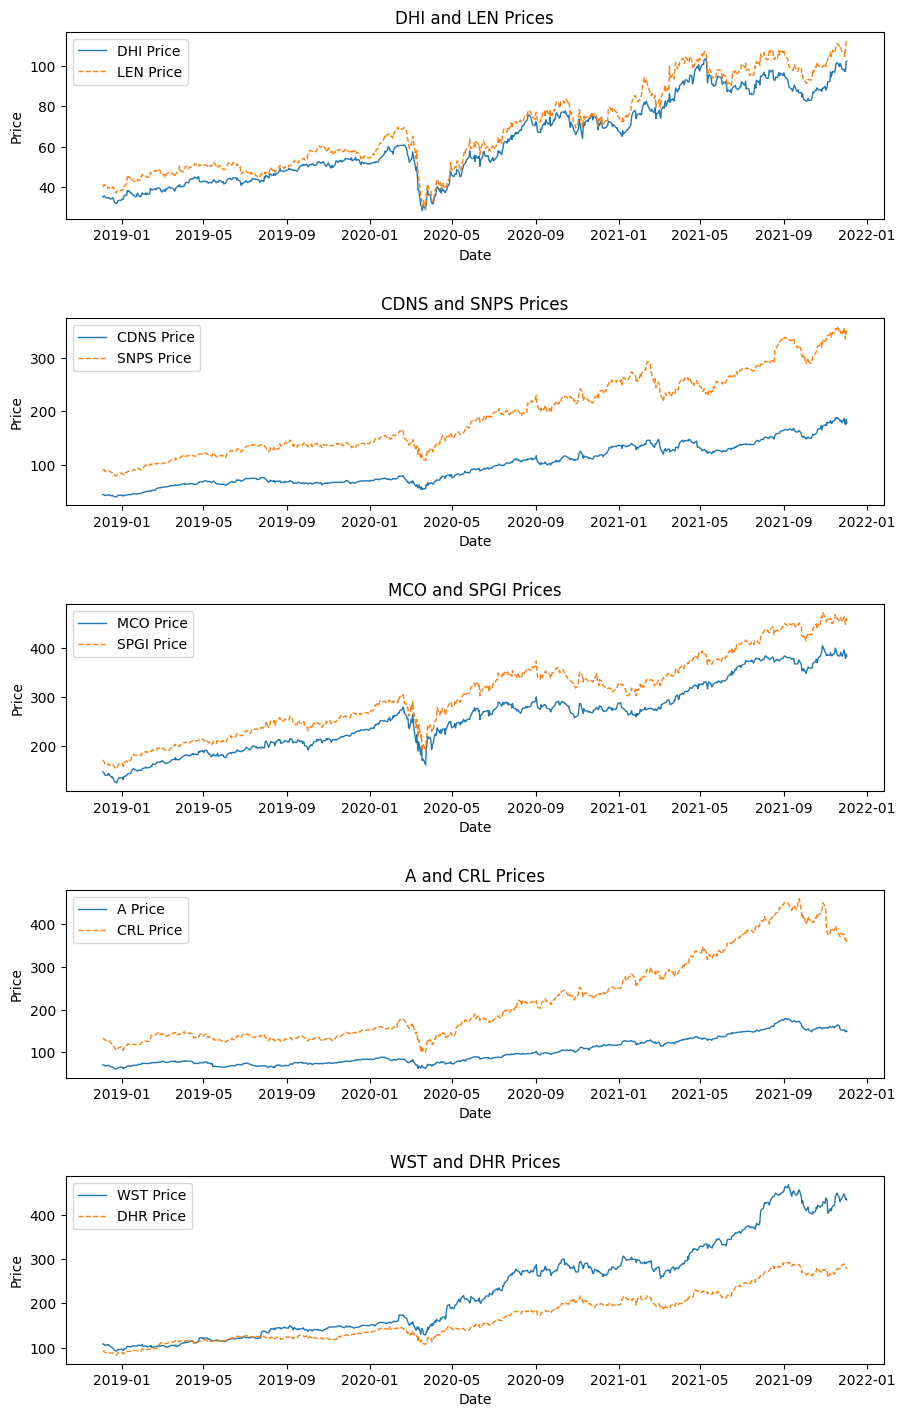

In [16]:
ticker_pairs = [
    ('DHI', 'LEN'),
    ('CDNS', 'SNPS'),
    ('MCO', 'SPGI'),
    ('A', 'CRL'),
    ('WST', 'DHR')
]

fig, axes = plt.subplots(nrows=len(ticker_pairs), ncols=1, figsize=(10, 15))
fig.tight_layout(pad=5.0)

for i, (ticker1, ticker2) in enumerate(ticker_pairs):
    axes[i].plot(df_pivot[ticker1], label=f'{ticker1} Price', linestyle='-', linewidth=1)
    axes[i].plot(df_pivot[ticker2], label=f'{ticker2} Price', linestyle='--', linewidth=1)
    axes[i].set_title(f'{ticker1} and {ticker2} Prices')
    axes[i].legend()
    axes[i].set_xlabel('Date')
    axes[i].set_ylabel('Price')

plt.show()

In [17]:
df_filled = df_pivot.fillna(method='ffill').fillna(method='bfill')
data_array = df_filled.to_numpy().T 
data_reshaped = data_array.reshape((data_array.shape[0], 1, data_array.shape[1]))

C:\Users\serga\AppData\Local\Temp\ipykernel_11268\66571024.py:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_filled = df_pivot.fillna(method='ffill').fillna(method='bfill')


In [18]:
# Применение PCA для уменьшения размерности
pca = PCA(n_components=0.9)
X_pca = pca.fit_transform(data_reshaped.reshape(data_reshaped.shape[0], -1))
X_pca_reshaped = X_pca.reshape(X_pca.shape[0], 1, X_pca.shape[1])
kmeans = TimeSeriesKMeans(n_clusters=250, metric="euclidean", max_iter=10)
clusters = kmeans.fit_predict(X_pca_reshaped)

In [19]:
silhouette_vals = silhouette_samples(data_reshaped.reshape(data_reshaped.shape[0], -1), clusters)
cluster_metrics = pd.DataFrame(columns=['cluster', 'average_silhouette', 'average_intra_distance'])
for cluster_num in np.unique(clusters):
     cluster_indices = np.where(clusters == cluster_num)[0]
     cluster_silhouette_vals = silhouette_vals[cluster_indices]
     cluster_data = data_reshaped[cluster_indices, :, :].reshape(len(cluster_indices), -1)
     intra_distances = euclidean_distances(cluster_data)
     intra_cluster_distance = np.mean(intra_distances)

     new_row = pd.DataFrame({
         'cluster': [cluster_num],
         'average_silhouette': [np.mean(cluster_silhouette_vals)],
         'average_intra_distance': [intra_cluster_distance]
     })
 
     cluster_metrics = pd.concat([cluster_metrics,new_row], ignore_index=True)
 
sorted_clusters = cluster_metrics.sort_values(by='average_silhouette', ascending=False)
print(sorted_clusters)

    cluster  average_silhouette  average_intra_distance
110     143            0.538058             4488.142245
93      117            0.300647              197.356751
35       45            0.298420               71.502723
11       13            0.237437              115.118453
138     180            0.235297             1342.573755
..      ...                 ...                     ...
173     229           -0.599862              747.099023
82      105           -0.604367              630.193344
22       25           -0.609484              440.979706
109     141           -0.609678             1094.525585
99      125           -0.661408              284.797850

[190 rows x 3 columns]


C:\Users\serga\AppData\Local\Temp\ipykernel_11268\894561657.py:16: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  cluster_metrics = pd.concat([cluster_metrics,new_row], ignore_index=True)


In [20]:
top_clusters = sorted_clusters.head(5)
top_pairs = []

for cluster_num in top_clusters['cluster']:
    cluster_indices = np.where(clusters == cluster_num)[0]
    if len(cluster_indices) >= 2:
        cluster_tickers = df_pivot.columns[cluster_indices]
        pair = cluster_tickers[:2].tolist()
        top_pairs.append(pair)

top_pairs[:5]

[['AZO', 'CMG'],
 ['STE', 'VRSK'],
 ['EQT', 'HST'],
 ['ACGL', 'FE'],
 ['ADBE', 'NFLX']]

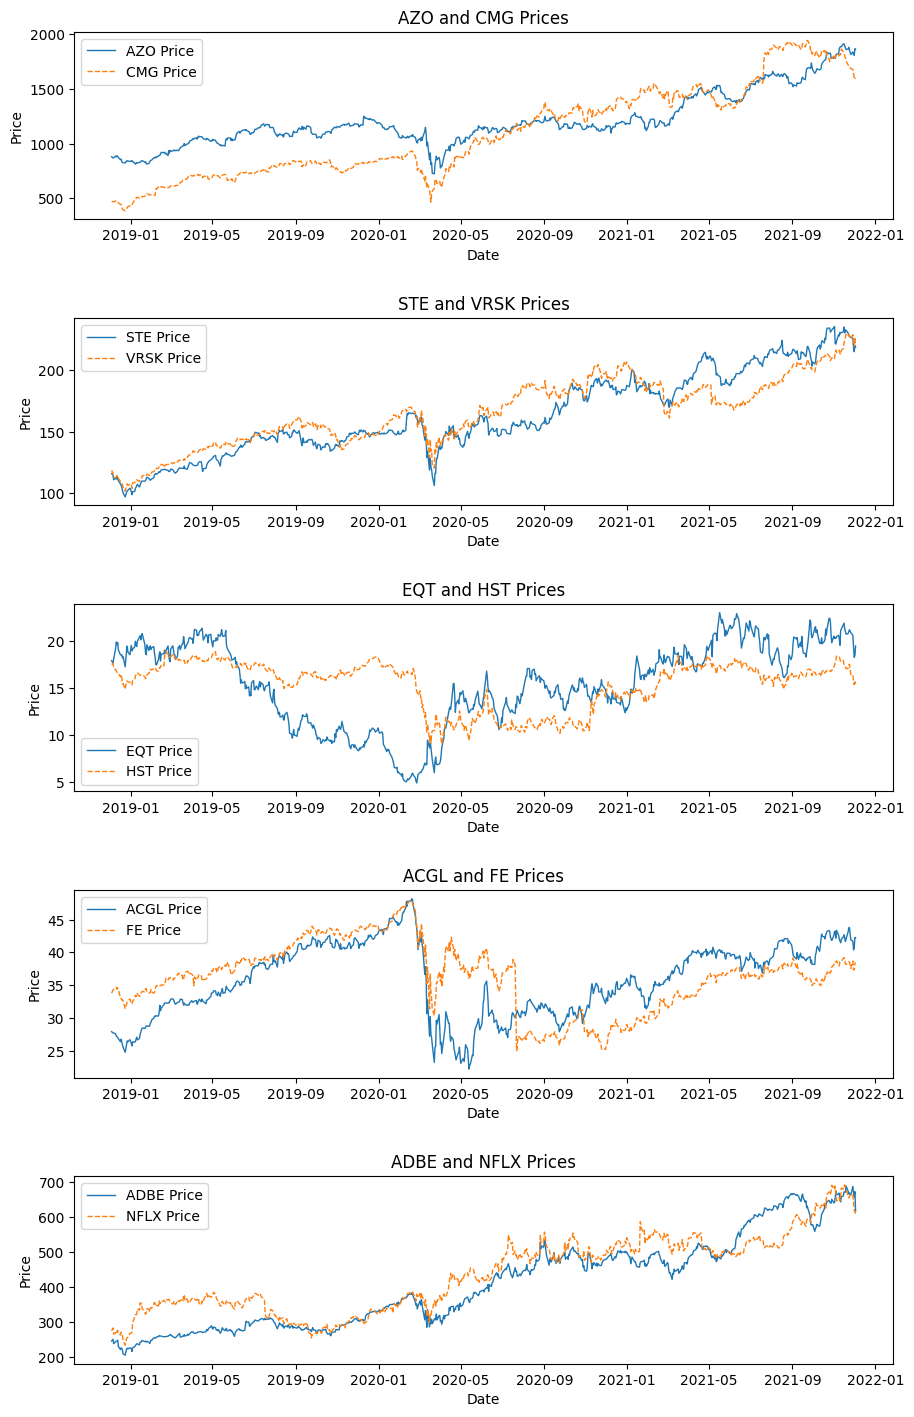

In [21]:
ticker_pairs = top_pairs[:5]

fig, axes = plt.subplots(nrows=len(ticker_pairs), ncols=1, figsize=(10, 15))
fig.tight_layout(pad=5.0)

for i, (ticker1, ticker2) in enumerate(ticker_pairs):
    axes[i].plot(df_pivot[ticker1], label=f'{ticker1} Price',  linestyle='-', linewidth=1)
    axes[i].plot(df_pivot[ticker2], label=f'{ticker2} Price',  linestyle='--', linewidth=1)
    axes[i].set_title(f'{ticker1} and {ticker2} Prices')
    axes[i].legend()
    axes[i].set_xlabel('Date')
    axes[i].set_ylabel('Price')

plt.show()

In [ ]:
# regression_pairs = {}
# 
# for ticker1 in df_pivot.columns:
#     for ticker2 in df_pivot.columns:
#         if ticker1 != ticker2:
#             temp_df = df_pivot[[ticker1, ticker2]].dropna()
#             X = temp_df[ticker1].values.reshape(-1, 1)  
#             y = temp_df[ticker2].values  
# 
#             model = LinearRegression().fit(X, y)
#             regression_pairs[(ticker1, ticker2)] = model.coef_[0]
# 
# top_regression_pairs = sorted(regression_pairs.items(), key=lambda x: abs(x[1]), reverse=True)[:10]
# top_regression_pairs

In [ ]:
def regression_model(pair):
    ticker1, ticker2 = pair
    temp_df = df_pivot[[ticker1, ticker2]].dropna()
    X = temp_df[ticker1].values.reshape(-1, 1)
    y = temp_df[ticker2].values
    model = LinearRegression().fit(X, y)
    return (ticker1, ticker2), model.coef_[0]

pairs = [(ticker1, ticker2) for ticker1 in df_pivot.columns for ticker2 in df_pivot.columns if ticker1 != ticker2]

with Pool(6) as pool:  
    regression_results = dict(pool.map(regression_model, pairs))

top_regression_pairs = sorted(regression_results.items(), key=lambda x: abs(x[1]), reverse=True)[:10]

for pair in top_regression_pairs:
    print(pair)

In [ ]:
scaler = MinMaxScaler()

ticker_pairs = [
    ('AMCR', 'NVR'),
    ('AMCR', 'CMG'),
    ('HBAN', 'NVR'),
    ('AMCR', 'MTD'),
    ('VZ', 'NVR')
]

fig, axes = plt.subplots(nrows=len(ticker_pairs), ncols=1, figsize=(10, 15))
fig.tight_layout(pad=5.0)

for i, (ticker1, ticker2) in enumerate(ticker_pairs):
    scaled_prices = scaler.fit_transform(df_pivot[[ticker1, ticker2]])
    axes[i].plot(df_pivot.index, scaled_prices[:, 0], label=f'{ticker1} Price',  linestyle='-', linewidth=1)
    axes[i].plot(df_pivot.index, scaled_prices[:, 1], label=f'{ticker2} Price',  linestyle='--', linewidth=1)
    
    axes[i].set_title(f'{ticker1} and {ticker2} Normalized Prices')
    axes[i].legend()
    axes[i].set_xlabel('Date')
    axes[i].set_ylabel('Normalized Price')

plt.show()

In [ ]:
df_aligned = df_pivot.dropna()

def coint_test(pair):
    ticker1, ticker2 = pair
    coint_score, p_value, _ = coint(df_aligned[ticker1], df_aligned[ticker2])
    return (ticker1, ticker2), (coint_score, p_value)

pairs = [(ticker1, ticker2) for ticker1 in df_aligned.columns for ticker2 in df_aligned.columns if ticker1 != ticker2]

with Pool(6) as pool:  
    cointegration_results = dict(pool.map(coint_test, pairs))

top_cointegrated_pairs = sorted(cointegration_results.items(), key=lambda x: x[1][1])[:5]

for pair in top_cointegrated_pairs:
    print(pair)

In [ ]:
scaler = MinMaxScaler()

ticker_pairs = np.nan

fig, axes = plt.subplots(nrows=len(ticker_pairs), ncols=1, figsize=(10, 15))
fig.tight_layout(pad=5.0)

for i, (ticker1, ticker2) in enumerate(ticker_pairs):
    scaled_prices = scaler.fit_transform(df_pivot[[ticker1, ticker2]])
    axes[i].plot(df_pivot.index, scaled_prices[:, 0], label=f'{ticker1} Price',  linestyle='-', linewidth=1)
    axes[i].plot(df_pivot.index, scaled_prices[:, 1], label=f'{ticker2} Price',  linestyle='--', linewidth=1)
    
    axes[i].set_title(f'{ticker1} and {ticker2} Normalized Prices')
    axes[i].legend()
    axes[i].set_xlabel('Date')
    axes[i].set_ylabel('Normalized Price')

plt.show()